<a href="https://colab.research.google.com/github/rihannh/ML-DeepL-Assignment-1/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import tensorflow_datasets as tfds
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [2]:
(train_ds, test_ds), info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [3]:
train_texts = [text.numpy().decode('utf8') for text, label in train_ds]
train_labels = [label.numpy() for text, label in train_ds]

test_texts = [text.numpy().decode('utf8') for text, label in test_ds]
test_labels = [label.numpy() for text, label in test_ds]

In [4]:

print(f"Jumlah data latih: {len(train_texts)}")
print(f"Jumlah data uji: {len(test_texts)}")

Jumlah data latih: 25000
Jumlah data uji: 25000


In [5]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("Semua paket NLTK sudah siap.")

Semua paket NLTK sudah siap.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    if not tokens: return ""
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return ' '.join(lemmatized_tokens)


In [7]:
from tqdm.auto import tqdm
# Terapkan fungsi preprocessing ke semua data latih
# tqdm akan menampilkan progress bar
print("\nMemulai preprocessing pada data latih...")
X_train_cleaned = [clean_and_lemmatize(text) for text in tqdm(train_texts)]

# Terapkan fungsi preprocessing ke semua data uji
print("Memulai preprocessing pada data uji...")
X_test_cleaned = [clean_and_lemmatize(text) for text in tqdm(test_texts)]


Memulai preprocessing pada data latih...


  0%|          | 0/25000 [00:00<?, ?it/s]

Memulai preprocessing pada data uji...


  0%|          | 0/25000 [00:00<?, ?it/s]

In [8]:
index_contoh = 10

print("\n--- VERIFIKASI HASIL ---")
print("\n[Teks Asli (Raw)]")
print(train_texts[index_contoh])
print("\n[Teks Setelah Preprocessing]")
print(X_train_cleaned[index_contoh])
print(f"\nLabel: {train_labels[index_contoh]} (0: Negatif, 1: Positif)")


--- VERIFIKASI HASIL ---

[Teks Asli (Raw)]
During a sleepless night, I was switching through the channels & found this embarrassment of a movie. What were they thinking?<br /><br />If this is life after "Remote Control" for Kari (Wuhrer) Salin, no wonder she's gone nowhere.<br /><br />And why did David Keith take this role? It's pathetic!<br /><br />Anyway, I turned on the movie near the end, so I didn't get much of the plot. But this must've been the best part. This nerdy college kid brings home this dominatrix-ish girl...this scene is straight out of the comic books -- or the cheap porn movies. She calls the mother anal retentive and kisses the father "Oh, I didn't expect tongue!" Great lines!<br /><br />After this, I had to see how it ended..<br /><br />Well, of course, this bitch from hell has a helluva past, so the SWAT team is upstairs. And yes...they surround her! And YES YES! The kid blows her brains out!!!! AHAHHAHAHAHA!!<br /><br />This is must-see TV. <br /><br />

[Teks S

In [9]:
VOCAB_SIZE = 10000
MAX_LEN = 256
OOV_TOKEN = "<OOV>"
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(X_train_cleaned)

X_train_seq = tokenizer.texts_to_sequences(X_train_cleaned)
X_test_seq = tokenizer.texts_to_sequences(X_test_cleaned)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

y_train = np.array(train_labels)
y_test = np.array(test_labels)

print("Bentuk data latih setelah tokenisasi dan padding (X_train_pad):")
print(X_train_pad.shape)

print("\nBentuk data uji setelah tokenisasi dan padding (X_test_pad):")
print(X_test_pad.shape)

Bentuk data latih setelah tokenisasi dan padding (X_train_pad):
(25000, 256)

Bentuk data uji setelah tokenisasi dan padding (X_test_pad):
(25000, 256)


In [10]:
# y_integers = np.argmax(y_train, axis=1)

# # Hitung bobot untuk setiap kelas
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(y_integers),
#     y=y_integers
# )
# # Ubah menjadi format dictionary yang bisa diterima Keras
# class_weights_dict = dict(enumerate(class_weights))

# print("Bobot Kelas yang akan digunakan:")
# print(class_weights_dict)

In [11]:
model = Sequential([
  Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
  Bidirectional(LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(0.001))),
  Dropout(0.3),
  Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  Dropout(0.3),
  Dense(1, activation='sigmoid')
])

model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [12]:
num_epochs = 20
batch_size = 64

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy'),
    ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.00001,
    verbose=1
)
]

history = model.fit(
    X_train_pad, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.6644 - loss: 0.7289 - val_accuracy: 0.8493 - val_loss: 0.3974 - learning_rate: 0.0010
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9020 - loss: 0.2913 - val_accuracy: 0.8579 - val_loss: 0.3543 - learning_rate: 0.0010
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9310 - loss: 0.2202 - val_accuracy: 0.8536 - val_loss: 0.3715 - learning_rate: 0.0010
Epoch 4/20
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9476 - loss: 0.1755
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
333/333 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.9475 - loss: 0.1755 - val_accuracy: 0.8581 - val_loss: 0.3736 - learning_rate: 0.0010
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9678 - loss: 0.1269 - val_accuracy: 0.8659 - val_loss: 0.4397 - learning_rate: 2.0000e-04
Epoch 6/20
332/333 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9782 - l

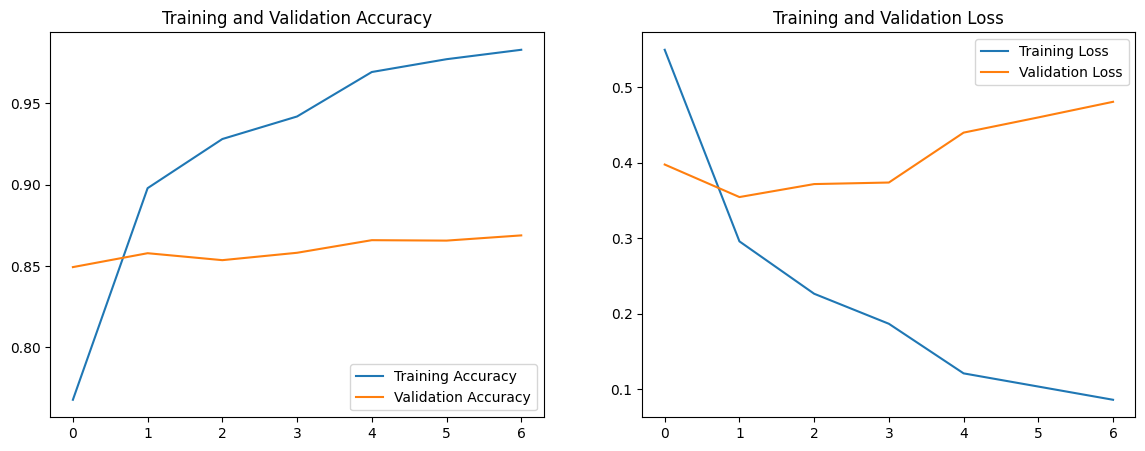

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Evaluate Model
Test Loss: 0.3751
Test Accuracy: 0.8436
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.79      0.83     12500
    Positive       0.81      0.90      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



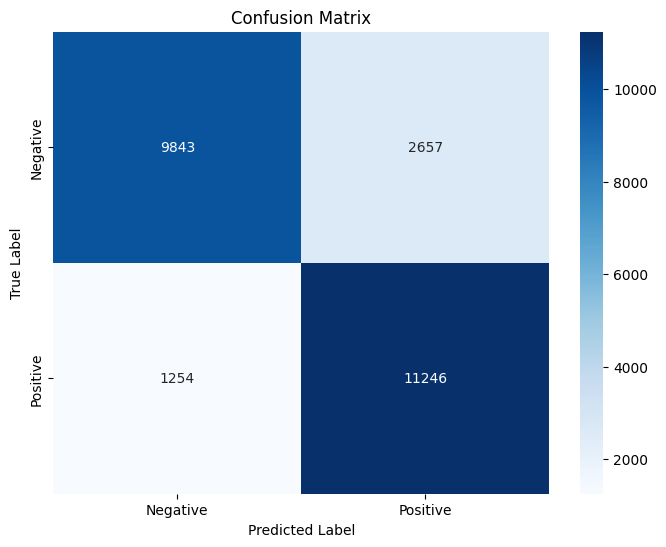

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


print("Evaluate Model")
results = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

y_pred_probs = model.predict(X_test_pad)
# For binary classification, threshold the probabilities at 0.5
y_pred = (y_pred_probs > 0.5).astype(int)

# y_test is already in the correct format (1-dimensional) for binary classification
y_test_labels = y_test

# Define class labels for binary classification
class_labels = ['Negative', 'Positive']

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=class_labels))

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()